In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import os
import glob

## Read the regular run input

In [3]:
## Collect clusters stats from all 10 groups
cAll = pd.DataFrame(columns=['genome', 'sample', 'primary_cluster',
       'original_secondary_cluster', 'secondary_cluster', 'part',
       'completeness', 'contamination', 'strain_heterogeneity',
       'length', 'N50', 'centrality'])

for n in range(1,11):

    # reads the cdb file
    cdb = pd.read_csv('./input/cdb_files/Cdb_'+str(n)+'.csv')
    cdb['sample'] = cdb['genome'].str.split('_').str[0]
    cdb = cdb[['genome', 'sample', 'primary_cluster','original_secondary_cluster', 'secondary_cluster']]
    cdb['part'] = 'p'+str(n)
    cdb['primary_cluster'] = cdb['part']+'-'+cdb['primary_cluster'].astype(str)
    cdb['secondary_cluster'] = cdb['part']+'-'+cdb['secondary_cluster'].astype(str)
    df = pd.DataFrame(cdb)

    # reads gen file and merge with cdb file
    gen = pd.read_csv('./input/genomes_files/genomeInformation_'+str(n)+'.csv')
    mrg = pd.merge(gen, df, on='genome', how='inner')

    # write to cALL file
    cAll = pd.concat([cAll, mrg], ignore_index=True)

cAll.tail()

,genome,sample,primary_cluster,original_secondary_cluster,secondary_cluster,part,completeness,contamination,strain_heterogeneity,length,N50,centrality
69328,VZZW6V_vamb.173899.fa,VZZW6V,p10-409,409_1,p10-409_1,p10,96.55,3.45,0.0,2563116,52472,0.982205
69329,VZZW6V_vamb.182971.fa,VZZW6V,p10-703,703_1,p10-703_1,p10,87.93,0.00,0.0,1489809,19724,0.977608
69330,VZZW6V_vamb.205379.fa,VZZW6V,p10-141,141_1,p10-141_1,p10,81.03,1.72,0.0,983639,85642,0.000000
69331,VZZW6V_vamb.51578.fa,VZZW6V,p10-534,534_1,p10-534_1,p10,100.00,0.00,0.0,1571046,525634,0.978252
69332,VZZW6V_vamb.76515.fa,VZZW6V,p10-1,1_1,p10-1_1,p10,99.14,13.79,100.0,1752869,228975,0.974250


In [4]:
sm = len(cAll['sample'].unique())
print('Number of samples: ', sm)

gn = len(cAll['genome'].unique())
print('Total number of bins: ', gn)

cl1 = len(cAll['primary_cluster'].unique())
print('Number of primary clusters: ', cl1)

cl2 = len(cAll['secondary_cluster'].unique())
print('Number of secondary clusters: ', cl2)

Number of samples:  1878
Total number of bins:  69333
Number of primary clusters:  8693
Number of secondary clusters:  9816


In [5]:
## Add quality annotations to all bins
conditions = [(cAll['completeness'] > 90) & (cAll['contamination'] < 5),
        (cAll['completeness'] <= 90) & (cAll['contamination'] < 10) | \
        (cAll['completeness'] > 90) & (cAll['contamination'] >= 5) & (cAll['contamination'] < 10),
        (cAll['contamination'] >= 10)]

values = ['HQ', 'MQ', 'LQ']
cAll['Bin_qual'] = np.select(conditions, values)
cAll.to_excel('results/Clusters_all_table.xlsx')

cAll['Bin_qual'].value_counts()

HQ    42049
MQ    21567
LQ     5717
Name: Bin_qual, dtype: int64

In [8]:
cAll.head() 

,genome,sample,primary_cluster,original_secondary_cluster,secondary_cluster,part,completeness,contamination,strain_heterogeneity,length,N50,centrality,Bin_qual
0,V0404P_181434.fa,V0404P,p1-654,654_1,p1-654_1,p1,98.28,3.45,0.0,1908262,52167,0.984998,HQ
1,V0404P_184256.fa,V0404P,p1-562,562_1,p1-562_1,p1,91.38,2.07,50.0,2178702,48365,0.981201,HQ
2,V0404P_maxbin.037.fa,V0404P,p1-975,975_1,p1-975_1,p1,89.42,2.59,0.0,2464390,38398,0.988677,MQ
3,V0404P_metabat.110.fa,V0404P,p1-639,639_1,p1-639_1,p1,98.28,1.72,0.0,2680403,63941,0.974003,HQ
4,V0404P_metabat.119.fa,V0404P,p1-112,112_1,p1-112_1,p1,89.66,2.07,100.0,1337532,16646,0.960543,MQ


In [46]:
## Add info about best bin from each cluster
bst = pd.read_csv('./input/flayer_bins_list.csv')
bst = bst.drop_duplicates(subset=['genome'], keep='first')
mrg = pd.merge(cAll, bst, on='genome', how='inner')
mrg = mrg[['genome','secondary_cluster']]
mrg.tail()

,genome,secondary_cluster
9854,VZXIHP_metabat.48_sub.fa,p10-332_1
9855,VZXIHP_vamb.13605.fa,p10-646_1
9856,VZXIHP_vamb.7376.fa,p10-407_1
9857,VZY957_maxbin.032.fa,p10-161_1
9858,VZZW6V_vamb.205379.fa,p10-141_1


In [53]:
## Add info about best bin from each cluster
mrg2 = cAll.merge(mrg, on='secondary_cluster', how='left')
mrg2.tail()

mrg2.to_excel('results/fLayer_table.xlsx')


In [27]:
a = set(bst['genome'].unique())
b = set(cAll['genome'].unique())

# WTF??
len(a.difference(b))

31

## Read result file from part 1.

In [61]:
cAll = pd.read_excel('results/fLayer_table.xlsx')
cAll.head(2)

,recovered_genome,sample,primary_cluster,original_secondary_cluster,secondary_cluster,part,completeness,contamination,strain_heterogeneity,length,N50,centrality,Bin_qual,bst_genome_1st_layer
0,V0404P_181434.fa,V0404P,p1-654,654_1,p1-654_1,p1,98.28,3.45,0.0,1908262,52167,0.984998,HQ,VOTVAJ_metabat.63.fa
1,V0404P_184256.fa,V0404P,p1-562,562_1,p1-562_1,p1,91.38,2.07,50.0,2178702,48365,0.981201,HQ,VGWZRG_metabat.106.fa


In [49]:
bst2 = pd.read_csv('./input/final_best_genomes.csv')
bst2.tail(2)

,final_genomes
2255,VZXIHP_vamb.13313.fa
2256,VZXIHP_vamb.28684.fa


In [52]:
# read the list of final set of the best bins
bst2_cdb = pd.read_csv('./input/final_Cdb.csv')
bst2_cdb.tail(2)

,genome,threshold,cluster_method,comparison_algorithm,greedy_representative,primary_cluster,original_secondary_cluster,secondary_cluster
9814,VZXIHP_metabat.45.fa,0.05,greedy,fastANI,True,1187,1187_1,1187_1
9815,VZXIHP_metabat.71.fa,0.05,greedy,fastANI,True,1822,1822_1,1822_1


In [54]:
bst2 = bst2.merge(bst2_cdb, left_on='final_genomes', right_on='genome',  how='left')
bst2 = bst2[['final_genomes','secondary_cluster']]
bst2.tail(2)

,final_genomes,secondary_cluster
2255,VZXIHP_vamb.13313.fa,541_1
2256,VZXIHP_vamb.28684.fa,1830_1


In [56]:
bst2_cdb = bst2_cdb.merge(bst2, on='secondary_cluster', how='left')
bst2_cdb.tail(2)

,genome,threshold,cluster_method,comparison_algorithm,greedy_representative,primary_cluster,original_secondary_cluster,secondary_cluster,final_genomes
9814,VZXIHP_metabat.45.fa,0.05,greedy,fastANI,True,1187,1187_1,1187_1,VZXIHP_metabat.45.fa
9815,VZXIHP_metabat.71.fa,0.05,greedy,fastANI,True,1822,1822_1,1822_1,VZXIHP_metabat.71.fa


In [62]:
cAll = cAll.merge(bst2_cdb, left_on='bst_genome_1st_layer', right_on='genome', how='left')
cAll.to_excel('results/FINAL_all_bins_all_clusters.xlsx')

In [38]:
# merge FINAL table for only the best bins
bst2 = bst2.merge(cAll, left_on='final_genomes', right_on='recovered_genome', how='left')
bst2.to_excel('results/FINAL_only_best_genomes.xlsx', index=False)


In [ ]:
# merge the FINAL table to get th info about all bins and 2 layers of clustering
allf = cAll.merge(bst2, left_on='recovered_genome', right_on='final_genomes', how='left')


## Vizualization

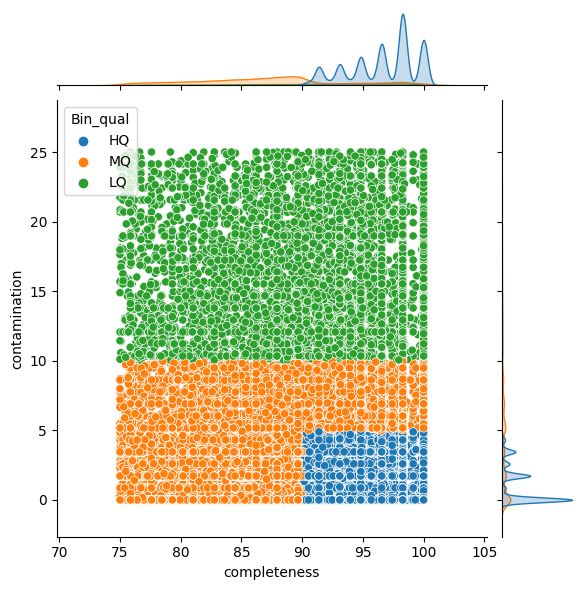

In [45]:
sns.jointplot(data=cAll, x="completeness", y="contamination", hue="Bin_qual")
plt.savefig('results/Clustering_all_bins_quality.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Clustering_all_bins_quality.svg', bbox_inches='tight')

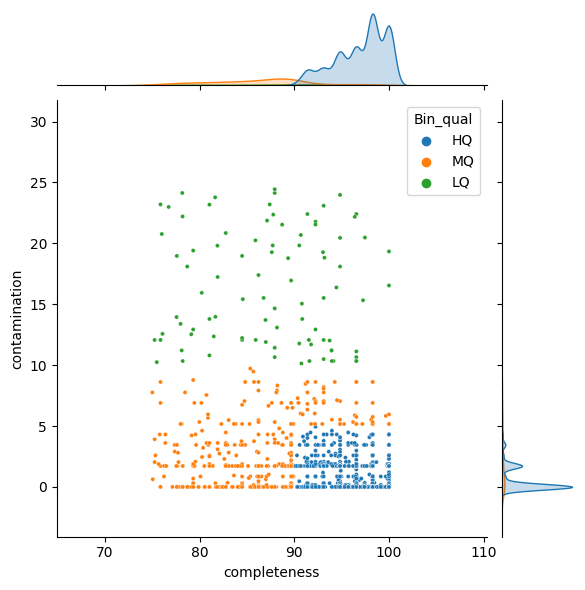

In [30]:
sns.jointplot(data=bst2, x="completeness", y="contamination", hue="Bin_qual", s=9)
plt.savefig('results/Best_genomes_bins_quality.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Best_genomes_bins_quality.svg', bbox_inches='tight')

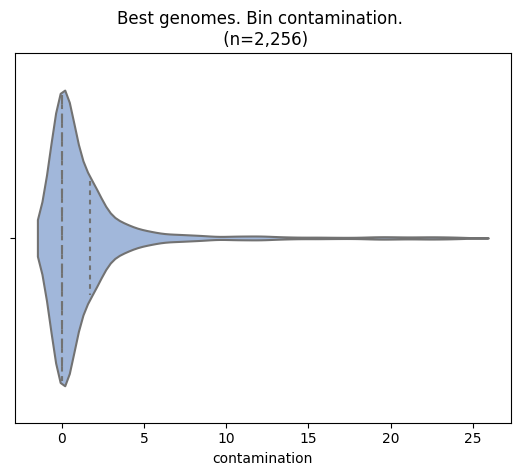

In [26]:
# Contamination destribution
sns.violinplot(data=bst2, x='contamination', inner="quartile", color='#98b5e3')
plt.title("Best genomes. Bin contamination. \n (n=2,256)")

plt.savefig('results/Best_genomes_BinContamination.jpg', dpi=150)

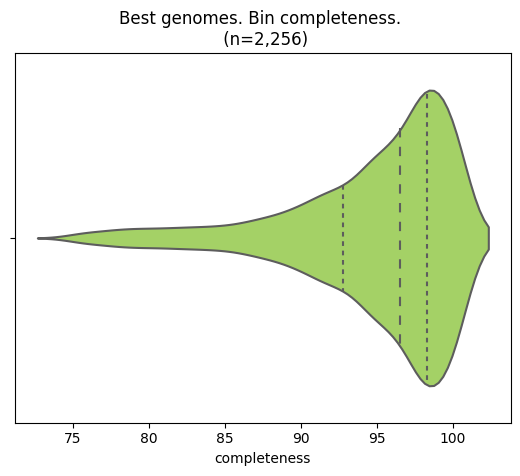

In [25]:
sns.violinplot(data=bst2, x='completeness', inner="quartile", color='#a7e354', alpha=0.5)
#sns.stripplot(data=bst2, x='completeness', color='grey', size=1)
plt.title("Best genomes. Bin completeness. \n (n=2,256)")

plt.savefig('results/Best_genomes_BinCompleteness.jpg', dpi=150)

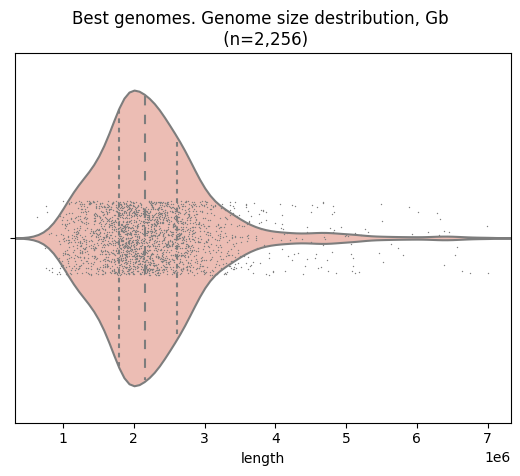

In [44]:
sns.violinplot(data=bst2, x='length', inner="quartile", color='#f5b6ab')
sns.stripplot(data=bst2, x='length', color='grey', size=1)
plt.title("Best genomes. Genome size destribution, Gb \n (n=2,256)")

plt.savefig('results/Best_genomes_GenSize1.jpg', dpi=150)

## Explore best bins from clusters

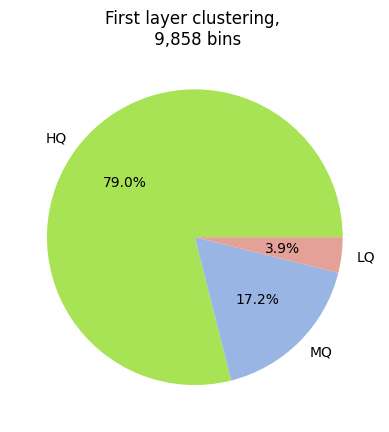

In [17]:
# First layer clustering
plt.pie(bst2['Bin_qual'].value_counts(), labels=['HQ', 'MQ', 'LQ'], autopct='%1.1f%%', colors=['#a7e354', '#98b5e3', '#e3a198'])
plt.title("First layer clustering, \n 9,858 bins")

plt.savefig('results/Best_genomes_from_clusters.jpg', dpi=150)